# Rice Image Classification Using CNNs & Transformers
Rishi Gandhi  J022 Assignment 3

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np # linear algebra
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
dir1 = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
# Detect classes
detection = [class_name for class_name in os.listdir(dir1) if class_name]
detection.remove('Rice_Citation_Request.txt')
print(detection)

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


In [3]:
class RiceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [4]:
def load_data(dir_path):
    data = []
    for class_name in os.listdir(dir_path):
        if class_name == 'Rice_Citation_Request.txt':
            continue
        class_path = os.path.join(dir_path, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(class_path, file_name)
                    data.append([file_path, class_name])
    return pd.DataFrame(data, columns=['FilePath', 'Class'])

In [5]:
df = load_data(dir1)
df['Class'] = df['Class'].astype('category').cat.codes  # Convert labels to numerical codes

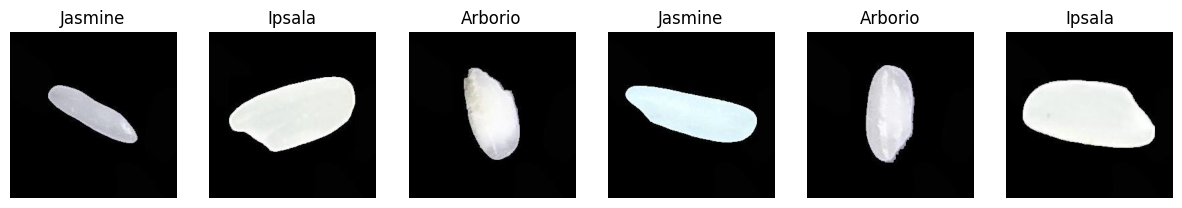

In [14]:
import random
import matplotlib.pyplot as plt

def plot_random_images(directory, detection, num_images=6):
    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    for i in range(num_images):
        # Randomly choose a class
        random_class = random.choice(detection)
        # Get the list of images in that class
        class_dir = os.path.join(directory, random_class)
        image_list = os.listdir(class_dir)
        # Randomly choose an image
        random_image = random.choice(image_list)
        # Load the image
        image_path = os.path.join(class_dir, random_image)
        image = Image.open(image_path)
        # Transform to tensor and back to PIL image (for any preprocessing)
        transform = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage()])
        image = transform(image)
        # Plot the image with the label as the title
        axes[i].imshow(image)
        axes[i].set_title(random_class)
        axes[i].axis('off')

    plt.show()

# Call the function to plot random images
plot_random_images(dir1, detection, num_images=6)

In [6]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Class'], random_state=42)

train_dataset = RiceDataset(dataframe=train_df, transform=transform)
val_dataset = RiceDataset(dataframe=val_df, transform=transform)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 18 * 18, 512),  # Assuming input size is 150x150
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
num_classes = len(df['Class'].unique())
model = SimpleCNN(num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()  # Ensure labels are long
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()  # Ensure labels are long
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()

        epoch_acc = val_corrects / len(val_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')

train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/20, Loss: 0.1263, Val Acc: 0.9927
Epoch 2/20, Loss: 0.0339, Val Acc: 0.9956
Epoch 3/20, Loss: 0.0232, Val Acc: 0.9935
Epoch 4/20, Loss: 0.0208, Val Acc: 0.9970
Epoch 5/20, Loss: 0.0188, Val Acc: 0.9977
Epoch 6/20, Loss: 0.0170, Val Acc: 0.9949
Epoch 7/20, Loss: 0.0166, Val Acc: 0.9976
Epoch 8/20, Loss: 0.0140, Val Acc: 0.9975
Epoch 9/20, Loss: 0.0147, Val Acc: 0.9961
Epoch 10/20, Loss: 0.0105, Val Acc: 0.9977
Epoch 11/20, Loss: 0.0133, Val Acc: 0.9980
Epoch 12/20, Loss: 0.0090, Val Acc: 0.9984
Epoch 13/20, Loss: 0.0154, Val Acc: 0.9961
Epoch 14/20, Loss: 0.0074, Val Acc: 0.9935
Epoch 15/20, Loss: 0.0109, Val Acc: 0.9981
Epoch 16/20, Loss: 0.0081, Val Acc: 0.9977
Epoch 17/20, Loss: 0.0115, Val Acc: 0.9982
Epoch 18/20, Loss: 0.0075, Val Acc: 0.9981
Epoch 19/20, Loss: 0.0100, Val Acc: 0.9781
Epoch 20/20, Loss: 0.0166, Val Acc: 0.9982


In [12]:
def evaluate_model(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data).item()
    
    val_acc = val_corrects / len(val_loader.dataset)
    print(f'Validation Accuracy: {val_acc * 100:.4f}%')

# Load the best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, val_loader)


Validation Accuracy: 99.8400%
